# Linear Regression Model for Predicting House Prices

In [8]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

# Exploratory Data Analysis

In [10]:
# load the datasets into dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [11]:
# show the first few records of train set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
# check the number of records and columns in both of datasets
print('Records in train dataset: ', len(train.index))
print('Columns in train dataset: ', len(train.columns))
print('Records in test dataset: ', len(test.index))
print('Columns in test dataset: ', len(test.columns))

Records in train dataset:  1460
Columns in train dataset:  81
Records in test dataset:  1459
Columns in test dataset:  80


In [13]:
# check the missing values
print ('Total missing values in train set', sum(train.isna().sum()))
print ('Total missing values in test set', sum(test.isna().sum()))

Total missing values in train set 6965
Total missing values in test set 7000


In [14]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [16]:
# Select columns with numerical data types
numeric_columns = train.select_dtypes(include=[np.number])

# Calculate the correlation matrix for these numerical columns
correlation_matrix = numeric_columns.corr()

# Display the features most correlated with SalePrice
print('Top Features Most Correlated with SalePrice:')
print(correlation_matrix['SalePrice'].sort_values(ascending=False).head(10), '\n')

# Display the features least correlated with SalePrice
print('Top Features Least Correlated with SalePrice:')
print(correlation_matrix['SalePrice'].sort_values(ascending=False).tail(5))

Top Features Most Correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

Top Features Least Correlated with SalePrice:
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


Text(0.5, 0, 'GrLivArea (Above ground living area in square feet)')

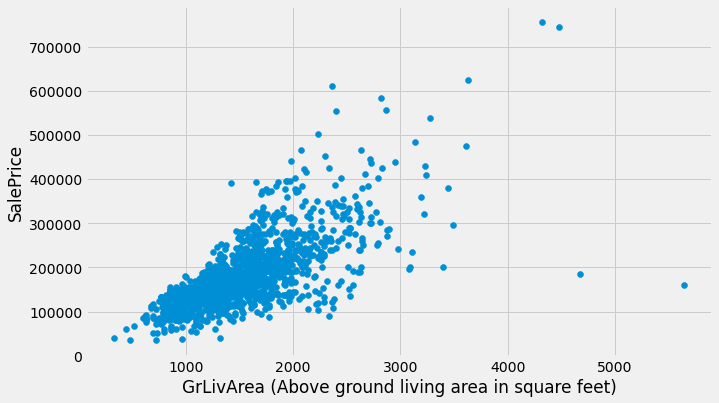

In [17]:
# Create a scatter plot of GrLivArea vs. SalePrice
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea (Above ground living area in square feet)')

Text(0.5, 0, 'GarageArea')

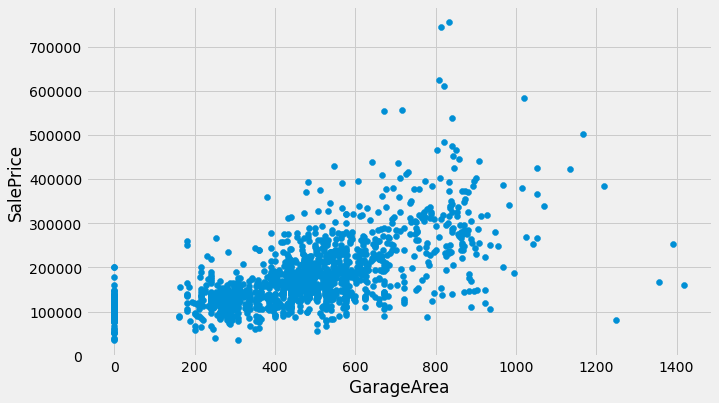

In [18]:
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

# Data Preprocessing

In [19]:
# remove GrLivArea outliers
train = train[train['GrLivArea'] < 4500]

In [20]:
# remove GarageArea outliers
train = train[train['GarageArea'] < 1200]

In [21]:
# Calculate the percentage of missing values for each column
missing_percentage = train.isnull().sum() / train.shape[0]

# Display columns with more than 80% missing values
print(missing_percentage[missing_percentage > 0.80])

# Drop columns that have more than 80% missing values
train = train.drop(columns=missing_percentage[missing_percentage > 0.80].index)

Alley          0.937414
PoolQC         0.995873
Fence          0.806740
MiscFeature    0.963549
dtype: float64


In [24]:
# Calculate the percentage of missing values for each column in the test dataset
test_missing_percentage = test.isnull().sum() / test.shape[0]

# Print columns with more than 80% missing values in the test dataset
print(test_missing_percentage[test_missing_percentage > 0.80])

# Remove columns that have more than 80% missing values from the test dataset
test = test.drop(columns=test_missing_percentage[test_missing_percentage > 0.80].index)

Series([], dtype: float64)


In [25]:
# Encode categorical variables using label encoding
le = preprocessing.LabelEncoder()
for column in train.columns:
    if train[column].dtype == 'O':
        train[column] = train[column].astype(str)
        le.fit(train[column])
        train[column] = le.transform(train[column])

In [26]:
# Encode categorical variables in the test dataset using label encoding
for column in test.columns:
    if test[column].dtype == 'O':
        test[column] = test[column].astype(str)
        le.fit(test[column])
        test[column] = le.transform(test[column])

In [27]:
# Fill missing values in the training dataset based on probability of occurrence
for column in train.columns:
    missing_values = train.isnull().values
    unique_values, counts = np.unique(train.values[~missing_values], return_counts=True)
    probabilities = counts / counts.sum()
    train.loc[train[column].isna(), column] = np.random.choice(unique_values, train[column].isnull().sum(), p=probabilities)

In [28]:
# Apply log transformation to features with skewness greater than 0.75
skewed_features = train.apply(lambda x: skew(x.dropna()))
highly_skewed = skewed_features[skewed_features > 0.75]
train[highly_skewed.index] = np.log1p(train[highly_skewed.index])

In [32]:
# deal with the skewness in the test data
skewed_test = test.apply(lambda x: skew(x.dropna()))
skewed_test = skewed_test[skewed_test > .75]
test[skewed_test.index] = np.log1p(test[skewed_test.index])

# Modelling

In [33]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
lr = linear_model.LinearRegression()

In [35]:
model = lr.fit(X_train, y_train)

In [36]:
# make predictions based on model
predictions = model.predict(X_test)

In [37]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.08676909179298682
MSE is: 0.016913749146517196
RMSE is: 0.13005287058161075


Text(0.5, 1.0, 'Linear Regression Model')

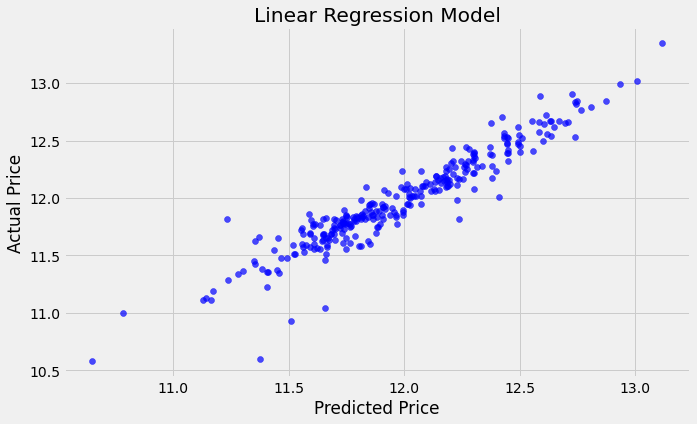

In [38]:
# alpha helps to show overlapping data
plt.scatter(predictions, y_test, alpha = 0.7, color = 'b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')